In [1]:
from matplotlib import pyplot as pl
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os

In [2]:
import warnings
from matplotlib.collections import LineCollection

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [3]:
def loaddata(filename):
    with open(filename, 'r') as f: colnames = f.readline().strip('\n').split(',')
    colnames[0] = 'step'
    data = np.loadtxt(filename, delimiter=',', skiprows=1, dtype={'names':colnames, 'formats':[np.int64]+[np.float64]*(len(colnames)-1)})
    return data

In [4]:
filename = os.path.join(os.pardir, 'paper_cases', 'drained_triaxial_psi0', 'drained.csv')
drained0p0 = loaddata(filename)
filename = os.path.join(os.pardir, 'paper_cases', 'drained_triaxial_psi7.5', 'drained.csv')
drained7p5 = loaddata(filename)

In [5]:
drained0p0.dtype.names, drained0p0['time'].max()

(('step',
  'Axial_stress',
  'Radial_stress',
  'Axial_strain',
  'Volumetric_strain',
  'Pore_pressure',
  'Effective_mean_stress',
  'Effective_deviatoric_stress',
  'Deviatoric_strain',
  'time'),
 14.999999999999998)

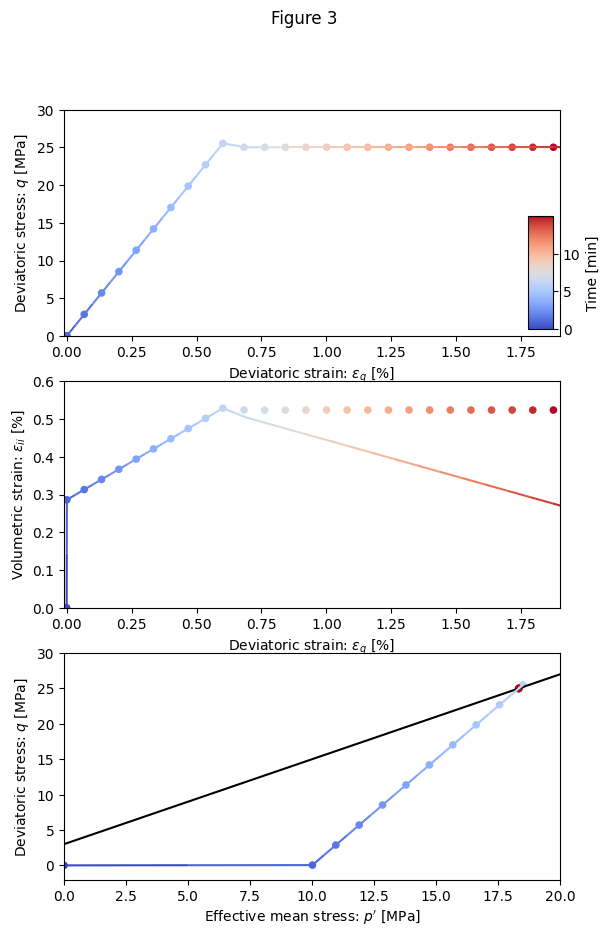

In [6]:
fig, axs = pl.subplots(3)
fig.set_figheight(10)
fig.suptitle('Figure 3')

# NB: deviatoric strain needed to be scaled by sqrt(2)
lines0 = colored_line(2**0.5*drained7p5['Deviatoric_strain'], drained7p5['Effective_deviatoric_stress'], drained7p5['time'], axs[0], cmap=cm.coolwarm)
axs[0].scatter(2**0.5*drained0p0['Deviatoric_strain'], drained0p0['Effective_deviatoric_stress'], s=20, c=drained0p0['time'], cmap=cm.coolwarm)
axs[0].set_xlim(-0.01,1.9)
axs[0].set_ylim(0,30)
axs[0].set_xlabel(r'Deviatoric strain: $\epsilon_q$ [%]')
axs[0].set_ylabel(r'Deviatoric stress: $q$ [MPa]')

# NB: deviatoric strain needed to be scaled by sqrt(2)
lines1 = colored_line(2**0.5*drained7p5['Deviatoric_strain'], drained7p5['Volumetric_strain'], drained7p5['time'], axs[1], cmap=cm.coolwarm)
axs[1].scatter(2**0.5*drained0p0['Deviatoric_strain'], drained0p0['Volumetric_strain'], s=20, c=drained0p0['time'], cmap=cm.coolwarm)
axs[1].set_xlim(-0.01,1.9)
axs[1].set_ylim(0,0.6)
axs[1].set_xlabel(r'Deviatoric strain: $\epsilon_q$ [%]')
axs[1].set_ylabel(r'Volumetric strain: $\epsilon_{ii}$ [%]')

axs[2].plot(np.arange(0,21,1), 1.2*np.arange(0,21,1) + 3, 'k')
lines1 = colored_line(drained7p5['Effective_mean_stress'], drained7p5['Effective_deviatoric_stress'], drained7p5['time'], axs[2], cmap=cm.coolwarm)
axs[2].scatter(drained0p0['Effective_mean_stress'], drained0p0['Effective_deviatoric_stress'], s=20, c=drained0p0['time'], cmap=cm.coolwarm)
axs[2].set_xlim(0,20)
axs[2].set_ylim(-2,30)
axs[2].set_xlabel(r'Effective mean stress: $p^\prime$ [MPa]')
axs[2].set_ylabel(r'Deviatoric stress: $q$ [MPa]')

axins = inset_axes(
    axs[0],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower right",
)
cb = fig.colorbar(lines0, cax=axins, ticks=np.arange(0.0, drained7p5['time'].max(), 5))
cb.set_label('Time [min]')

In [7]:
filename = os.path.join(os.pardir, 'paper_cases', 'undrained_triaxial_psi0', 'undrained.csv')
undrained0p0 = loaddata(filename)
filename = os.path.join(os.pardir, 'paper_cases', 'undrained_triaxial_psi7.5', 'undrained.csv')
undrained7p5 = loaddata(filename)

In [8]:
undrained0p0.dtype.names, undrained0p0['time'].max()

(('step',
  'Axial_stress',
  'Radial_stress',
  'Axial_strain',
  'Volumetric_strain',
  'Pore_pressure',
  'Effective_mean_stress',
  'Effective_deviatoric_stress',
  'Deviatoric_strain',
  'time'),
 14.999999999999998)

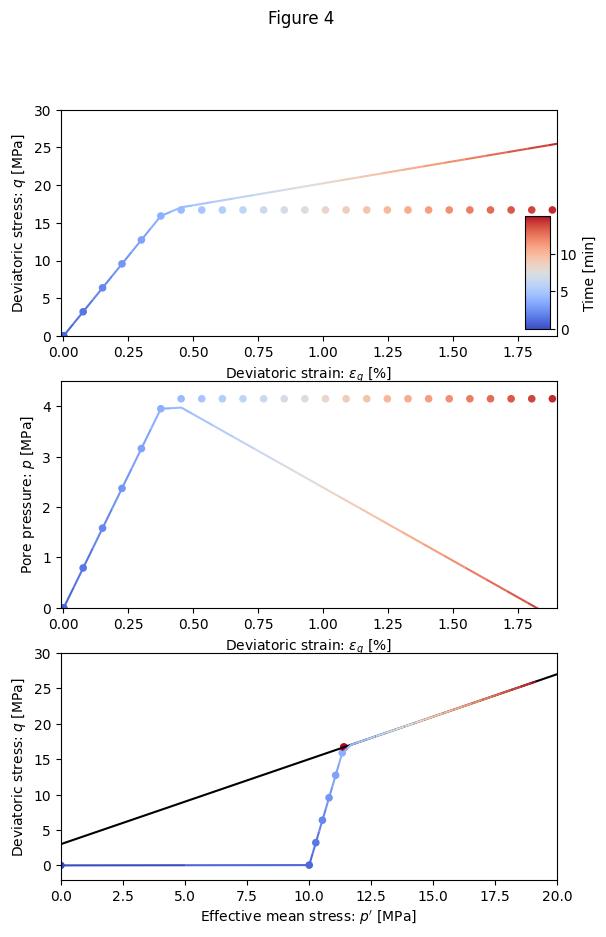

In [9]:
fig, axs = pl.subplots(3)
fig.set_figheight(10)
fig.suptitle('Figure 4')

# NB: deviatoric strain needed to be scaled by sqrt(2)
lines0 = colored_line(2**0.5*undrained7p5['Deviatoric_strain'], undrained7p5['Effective_deviatoric_stress'], undrained7p5['time'], axs[0], cmap=cm.coolwarm)
axs[0].scatter(2**0.5*undrained0p0['Deviatoric_strain'], undrained0p0['Effective_deviatoric_stress'], s=20, c=undrained0p0['time'], cmap=cm.coolwarm)
axs[0].set_xlim(-0.01,1.9)
axs[0].set_ylim(0,30)
axs[0].set_xlabel(r'Deviatoric strain: $\epsilon_q$ [%]')
axs[0].set_ylabel(r'Deviatoric stress: $q$ [MPa]')

# NB: deviatoric strain needed to be scaled by sqrt(2)
lines1 = colored_line(2**0.5*undrained7p5['Deviatoric_strain'], undrained7p5['Pore_pressure'], undrained7p5['time'], axs[1], cmap=cm.coolwarm)
axs[1].scatter(2**0.5*undrained0p0['Deviatoric_strain'], undrained0p0['Pore_pressure'], s=20, c=undrained0p0['time'], cmap=cm.coolwarm)
axs[1].set_xlim(-0.01,1.9)
axs[1].set_ylim(0,4.5)
axs[1].set_xlabel(r'Deviatoric strain: $\epsilon_q$ [%]')
axs[1].set_ylabel(r'Pore pressure: $p$ [MPa]')

axs[2].plot(np.arange(0,21,1), 1.2*np.arange(0,21,1) + 3, 'k')
lines1 = colored_line(undrained7p5['Effective_mean_stress'], undrained7p5['Effective_deviatoric_stress'], undrained7p5['time'], axs[2], cmap=cm.coolwarm)
axs[2].scatter(undrained0p0['Effective_mean_stress'], undrained0p0['Effective_deviatoric_stress'], s=20, c=undrained0p0['time'], cmap=cm.coolwarm)
axs[2].set_xlim(0,20)
axs[2].set_ylim(-2,30)
axs[2].set_xlabel(r'Effective mean stress: $p^\prime$ [MPa]')
axs[2].set_ylabel(r'Deviatoric stress: $q$ [MPa]')

axins = inset_axes(
    axs[0],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower right",
)
cb = fig.colorbar(lines0, cax=axins, ticks=np.arange(0.0, undrained7p5['time'].max(), 5))
cb.set_label('Time [min]')

In [10]:
filename = os.path.join(os.pardir, 'paper_cases', 'thermal_triaxial_drained_heating', 'thermal.csv')
thermalh = loaddata(filename)
filename = os.path.join(os.pardir, 'paper_cases', 'thermal_triaxial_drained_cooling', 'thermal.csv')
thermalc = loaddata(filename)

In [11]:
thermalh.dtype.names, thermalh['time'].max()

(('step',
  'Axial_stress',
  'Radial_stress',
  'Axial_strain',
  'Volumetric_strain',
  'Pore_pressure',
  'Temperature',
  'Effective_mean_stress',
  'Effective_deviatoric_stress',
  'Deviatoric_strain',
  'time'),
 15.0)

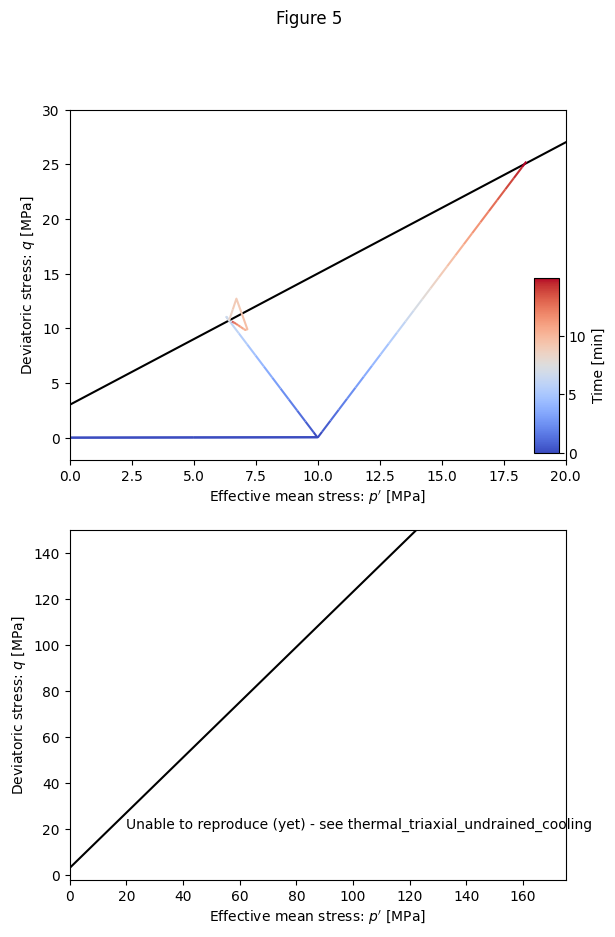

In [12]:
fig, axs = pl.subplots(2)
fig.set_figheight(10)
fig.suptitle('Figure 5')

axs[0].plot(np.arange(0,21,1), 1.2*np.arange(0,21,1) + 3, 'k')
lines1 = colored_line(thermalh['Effective_mean_stress'], thermalh['Effective_deviatoric_stress'], thermalh['time'], axs[0], cmap=cm.coolwarm)
lines1c = colored_line(thermalc['Effective_mean_stress'], thermalc['Effective_deviatoric_stress'], thermalc['time'], axs[0], cmap=cm.coolwarm)
axs[0].set_xlim(0,20)
axs[0].set_ylim(-2,30)
axs[0].set_xlabel(r'Effective mean stress: $p^\prime$ [MPa]')
axs[0].set_ylabel(r'Deviatoric stress: $q$ [MPa]')

axs[1].plot(np.arange(0,175,1), 1.2*np.arange(0,175,1) + 3, 'k')
# FIXME!
axs[1].text(20, 20, "Unable to reproduce (yet) - see thermal_triaxial_undrained_cooling")
axs[1].set_xlim(0,175)
axs[1].set_ylim(-2,150)
axs[1].set_xlabel(r'Effective mean stress: $p^\prime$ [MPa]')
axs[1].set_ylabel(r'Deviatoric stress: $q$ [MPa]')

axins = inset_axes(
    axs[0],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower right",
)
cb = fig.colorbar(lines0, cax=axins, ticks=np.arange(0.0, thermalh['time'].max(), 5))
cb.set_label('Time [min]')